In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from catboost import Pool, CatBoostRegressor

### Можно ли решить задачу с наскока?

Сперва стоит подгрузить данные и посмотреть на то, с чем нам придётся работать.

В этои соревновании участникам предоставляются 4 набора из пар файлов (train и test):
1. train_main.parquet (279 признаков + ключ)
2. train_card_spending.parquet (630 признаков + ключ)
3. train_mcc_operations.parquet (1640 признаков + ключ)
4. train_mcc_preferences.parquet (2112 признаков + ключ)

Для простоты, попробуем использовать первый набор (*_main.parquet*).

#### Данные с признаками (1 из 4):


In [2]:
train = pd.read_parquet('data/task3/train_main.parquet')
test = pd.read_parquet('data/task3/test_main.parquet')

In [3]:
print('Данные для обучения:', train.shape)
print('Тестовые данные:', test.shape)

Данные для обучения: (213345, 280)
Тестовые данные: (318451, 280)


In [4]:
train.head(n = 5)

,user_id,app_children_cnt,app_dependent_cnt,app_family_cnt,app_income_app,app_real_estate_ind,app_vehicle_ind,avg_dep_avg_balance_12month_amt,avg_dep_avg_balance_12month_amt_term,avg_dep_avg_balance_12month_amt_term_savings,...,savings_sum_oms_debet_3m,savings_sum_oms_debet_6m,savings_sum_oms_debet_9m,savings_sum_oms_debet_12m,savings_service_model_cd,savings_pension_flg,savings_deposit_flg,savings_safe_acc_flg,savings_broker_flg,savings_oms_flg
0,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4027.373535,...,34.613216,0.000000,4.310414,75.214180,Массовый,0,0,1,0,0
1,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.237672,0.000000,0.000000,0.000000,Массовый,0,0,1,0,0
2,12,0.0,0.0,0.0,105372.960938,0.0,0.0,315208.781250,NaN,274816.375000,...,0.000000,53.134129,90.025238,0.000000,Массовый,0,0,1,0,0
3,13,1.0,0.0,3.0,0.000000,0.0,0.0,43187.953125,NaN,5277.233887,...,0.000000,22.276114,82.070015,117.386795,Массовый,0,0,1,0,0
4,15,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.000000,...,0.000000,0.000000,0.000000,33.072178,Массовый,0,0,1,0,0


#### Особенности данных

Сразу видно очень много пропусков. 

Наверное с пропусками даже придётся что-то делать, ведь где-то их 50% или больше.

In [5]:
missing_values = train.isnull().sum().sort_values(ascending = False)
missing_values = missing_values[missing_values > 0]
print('\nColumns with missing values:\n', missing_values)


Columns with missing values:
 vehicle_counrty_type_nm    206739
max_amt_foreign_cur_5y     201136
max_amt_dep_6m             182526
min_amt_term_g1y           180330
max_amt_dep_act            175074
                            ...  
cnt_foreign_cur_5y             26
cnt_save_5y                    26
cnt_grow_5y                    26
cnt_term_g1y                   26
cnt_manage_5y                  26
Length: 167, dtype: int64


Интересно, а в тестовых данных же всё точно так же? 

Наверное, нужно будет это проверить 🤔️️️️️️

Для некоторых алгоритмов будет неловко, если появятся новые признаки с пропусками, которых не было в обучающих данных  👀️️️️️️

#### Типы  данных

Стоит верхнеуровнево посмотреть что находится внутри. Особенно интересуют категориальные признаки.

In [6]:
train.dtypes.value_counts()

float64    266
object       8
int32        6
Name: count, dtype: int64

Категориальные признаки стоит отдельно выделить и сохранить для Catboost.

In [7]:
features = train.columns

categorical_features = train[features].select_dtypes(include=['object']).columns

for feature in categorical_features:
    train[feature] = train[feature].astype(str)

categorical_features_indices = np.where(train.dtypes == 'object')[0]

Для первого подхода к снаряду, этого хватит. Не хватает только целевой переменной.

### Целевая переменная



In [8]:
target = pd.read_csv('data/task3/train_target.csv')
target.shape

(213345, 2)

In [9]:
target.head(5)

,user_id,target
0,9,0.00000
1,11,0.00000
2,12,219932.90625
3,13,631.77002
4,15,0.00000


Мы решаем задачу регрессии. Из описания соревнования, нам требуется предсказать:

> 50 перцентиль распределения суммарных остатков на всех накоп.ительных счетах клиента на горизонте +2 мес. от отчетной даты



In [10]:
target['target'].describe()

count    2.133450e+05
mean     2.210490e+05
std      9.894988e+05
min     -7.100000e-01
25%      0.000000e+00
50%      3.174000e+01
75%      1.000027e+05
max      1.015605e+08
Name: target, dtype: float64

Целевая переменная точно требует ее преобразовать. Посмотрим как она выглядит после log1p:

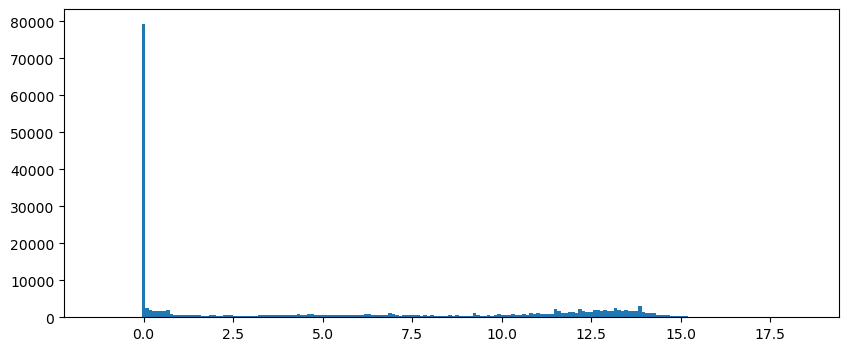

In [11]:
plt.figure(figsize=(10,4))

plt.hist(np.log1p(target['target']), bins = 200);

В распределении очень много нулей, так что стоит смотреть чуть уже:

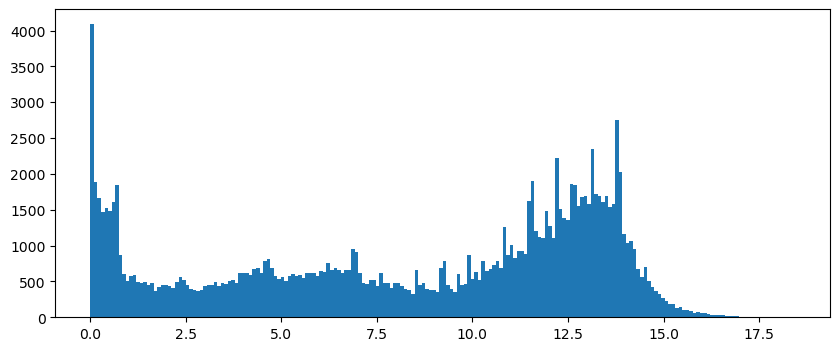

In [12]:
plt.figure(figsize=(10,4))

plt.hist(np.log1p(target.loc[target['target'] > 0, 'target']), bins = 200);

Распределение выглядит очень похожим на смесь:
- Есть клиенты с значениями около нуля
- Есть компонента смеси с центром в районе 6, то есть ~400 (np.exp(6) - 1)
- Есть компонента справа, с центров в районе 13, то есть ~440,000
- И есть еще клиенты с ровно 0, которых мы убрали с графика

Выглядит заманчиво и для ML, и визуализации. Но нас пока интересует только сабмит.

### Catboost

Начнём собирать всё что нам потребуется дя обучения Catboost-а.

- Будем ли мы проверять, что порядок `user_id` полностью совпадает в train и target?
- Будем ли мы сразу настраивать свою валидацию и делить данные?
- Или может быть будем что-либо преобразовывать?

Нет, нас интересует atboost сабмит ASAP 🤗️️️️️️ 

In [13]:
train_pool = Pool(data = train, 
                  label = np.log1p(target['target']), 
                  cat_features = categorical_features_indices)

#### Обучение

Главные настройки, которые нам стоит учесть:

- Так как метрика соревнования это RMSLE, а мы уже логарифмировали (log1p) целевую переменную, оптимизировать мы будем RMSE
- У нас много пропусков в данных, поэтому нам очень повезло что у Catboost есть настройка nan_mode

In [14]:
model = CatBoostRegressor(iterations = 100, 
                          depth = 6, 
                          learning_rate = 0.1, 
                          loss_function = 'RMSE', 
                          nan_mode = 'Min', 
                          random_seed = 314,
                          verbose = 10)


In [15]:
model.fit(train_pool)

0:	learn: 5.1242446	total: 128ms	remaining: 12.7s
10:	learn: 2.7903763	total: 891ms	remaining: 7.21s
20:	learn: 2.2642536	total: 1.65s	remaining: 6.21s
30:	learn: 2.1466213	total: 2.33s	remaining: 5.18s
40:	learn: 2.1033289	total: 3s	remaining: 4.31s
50:	learn: 2.0807207	total: 3.63s	remaining: 3.48s
60:	learn: 2.0606817	total: 4.26s	remaining: 2.72s
70:	learn: 2.0467002	total: 4.91s	remaining: 2s
80:	learn: 2.0315319	total: 5.6s	remaining: 1.31s
90:	learn: 2.0204322	total: 6.22s	remaining: 615ms
99:	learn: 2.0125081	total: 6.84s	remaining: 0us


Мы успешно обучили модель 🌟️️️️️️

И вправду — зачем нам валидация, если можно ее сразу отправить в соревнование и узнать наш результат на лидерборде? Он же не будет прямо сильно хуже чем в логе обучения? (ведь правда, да?)

### Подготовка сабмита

Посмотрим на пример рабочего бейзлайн решения. 

Именно в таком формате платформа ждет от нас решения:

In [16]:
sample = pd.read_csv('data/task3/sample_submit_naive.csv')
sample.shape

(318451, 2)

In [17]:
sample.head(5)

,user_id,predict
0,1000008,1.004656e+06
1,1000009,0.000000e+00
2,1000013,5.047758e+02
3,1000016,1.680799e+05
4,1000017,2.222542e+02


С форматом тоже всё понятно. 

Важно заметить, что предсказания от нас ждут без преобразований целевой переменной, так что нужно будет сделать обратные преобразования предсказаний нашей модели.

#### Использование модели 

Тестовые данные у нас уже есть, но их нужно подготовить для формата Catboost-а.

In [18]:
test.head(5)

,user_id,app_children_cnt,app_dependent_cnt,app_family_cnt,app_income_app,app_real_estate_ind,app_vehicle_ind,avg_dep_avg_balance_12month_amt,avg_dep_avg_balance_12month_amt_term,avg_dep_avg_balance_12month_amt_term_savings,...,savings_sum_oms_debet_3m,savings_sum_oms_debet_6m,savings_sum_oms_debet_9m,savings_sum_oms_debet_12m,savings_service_model_cd,savings_pension_flg,savings_deposit_flg,savings_safe_acc_flg,savings_broker_flg,savings_oms_flg
0,1000008,NaN,NaN,NaN,NaN,NaN,NaN,998138.562500,2678.699219,1.009246e+06,...,0.000000,0.000000,67.893509,0.000000,Массовый,0,0,1,0,0
1,1000009,0.0,NaN,NaN,29125.394531,0.0,0.0,0.000030,NaN,NaN,...,8.407050,54.111416,70.213890,82.739632,Массовый,0,0,1,0,0
2,1000013,0.0,0.0,0.0,59536.816406,0.0,0.0,54086.031250,NaN,3.513455e+04,...,0.000000,0.000000,0.000000,56.554066,Массовый,0,0,1,0,0
3,1000016,0.0,NaN,NaN,66908.468750,0.0,0.0,60340.105469,NaN,6.347482e+04,...,33.321732,59.461399,0.000000,0.000000,Массовый,0,0,1,1,0
4,1000017,NaN,NaN,NaN,NaN,NaN,NaN,0.000030,NaN,0.000000e+00,...,26.527195,0.000000,56.962830,59.217648,Массовый,0,0,1,0,0


In [19]:
test_pool = Pool(data = test, 
                 cat_features = categorical_features_indices)

In [20]:
test_predict = model.predict(test_pool)
test_predict.shape

(318451,)

Обратные преобразования (не забываем -1):

In [21]:
test_full_predict = np.exp(test_predict) - 1

#### Упаковка сабмита

Так как мы торопимся отправить решение, мы снова доверимся воле случая, что все 'user_id' отсортированы за нас 🌚️️️️️️

И мы просто перепишем предсказания в исходном сабмит файле.

In [22]:
sample['predict'] = test_full_predict

In [23]:
sample.head(5)

,user_id,predict
0,1000008,290314.317272
1,1000009,-0.030440
2,1000013,11.244460
3,1000016,271.858813
4,1000017,12.335367


Финишная прямая — пишем файл:


In [24]:
sample.to_csv('submit_baseline_catboost.csv', index=False)

И... результат на паблике это 4.169190539294088	

- Это лучше чем наивный сабмит с 5.848489205052006
- Но это точно не метрика, показываемая в логах при обучении
- И этот результат вряд ли пошёл бы в продакшен

Можно ли это улучшить? 